In [1]:
!pip install AFQ-Browser

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 20.0 MB 7.8 MB/s eta 0:00:01
     |████████████████████████████████| 159 kB 41.7 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 2.0 MB/s  eta 0:00:01
     |████████████████████████████████| 291 kB 59.2 MB/s eta 0:00:01
     |████████████████████████████████| 961 kB 51.6 MB/s eta 0:00:01
  Created wheel for AFQ-Browser: filename=AFQ_Browser-0.2.4-py3-none-any.whl size=20023826 sha256=f329e272c33b86e5c7e5de1b937f01610eb4cc097bed6d283105bc83d6356a2c
  Stored in directory: /home/romain/.cache/pip/wheels/15/cf/77/084c2abda80114293ead84ded467ebefe3054e75ba0f4d8144
Successfully built AFQ-Browser


In [4]:
!pwd
afqbrowser-assemble afq.mat

SyntaxError: invalid syntax (<ipython-input-4-ff7506f109d0>, line 2)

In [1]:
from tractseg.data import dataset_specific_utils
from tractseg.libs.AFQ_MultiCompCorrection import AFQ_MultiCompCorrection
from tractseg.libs.AFQ_MultiCompCorrection import get_significant_areas
from tractseg.libs import metric_utils
from tractseg.libs import tracking
from tractseg.libs import tractometry
from dipy.tracking.utils import length

import os
import argparse
import math
from decimal import Decimal
from os.path import join
import statsmodels.api as sm

import numpy as np
import matplotlib.pyplot as plt
import plotnine as p9

import seaborn as sns
import scipy.stats
import pandas as pd
from tqdm import tqdm

import glob as glob
import nibabel as nib
from scipy.stats import t as t_dist
from sklearn.linear_model import LinearRegression

from dipy.io.streamline import load_tck
from dipy.io.streamline import load_trk

from dipy.tracking.streamline import transform_streamlines
from dipy.viz import actor, window
from dipy.tracking.utils import length
import dipy as dp
print(dp.__version__)

import seaborn as sns  # import in function to avoid error if not installed (this is only needed in this function)
from dipy.viz import actor, window
from scipy.ndimage.morphology import binary_dilation
from dipy.tracking.streamline import transform_streamlines
from scipy.ndimage.morphology import binary_dilation
from dipy.tracking.streamline import set_number_of_points
from dipy.tracking.streamline import length as sl_length
from dipy.tracking.streamline import Streamlines
from dipy.segment.clustering import QuickBundles
from dipy.segment.metric import AveragePointwiseEuclideanMetric
from scipy.spatial import cKDTree    
import statsmodels as sm

#from tractseg.libs import vtk_utils
#from tractseg.libs import plot_utils
#from tractseg.data import dataset_specific_utils
#from tractseg.libs import fiber_utils
#from tractseg.libs import img_utils
#%magic
#%matplotlib inline


1.4.0


In [3]:
STUDY_PATH='/NAS/dumbo/protocoles/CogPhenoPark/'
IMAGES_DIR=STUDY_PATH+'TractSeg_output/'
TRACTO_DIR=STUDY_PATH+'TractSeg/'
FILE_PATH=os.path.join(STUDY_PATH,'liste_pts.csv')

In [4]:
listeGeneric=(['''AF''','''ATR''','''CG''','''FX''','''IFO''','''ILF''','''MLF''','''OR''','''SLF_III''','''SLF_II''','''SLF_I''','''ST_FO''','''ST_OCC''','''ST_PAR''','''ST_POSTC''','''ST_PREC''','''ST_PREF''','''ST_PREM''','''STR''','''T_OCC''','''T_PAR''','''T_POSTC''','''T_PREC''','''T_PREF''','''T_PREM''','''UF'''])
print(len(listeGeneric))
listeGenericT=(['''AF'''])
listeSpecific=(['''Accumbens_Amygdala''','''Accumbens_cACC''','''Accumbens_Insula''','''Accumbens_lForb''','''Accumbens_mForb''','''Accumbens_rACC''','''Accumbens_Thalamus''','''Amygdala_Caudate''','''Amygdala_Insula''','''Amygdala_lForb''','''Amygdala_Putamen''','''Amygdala_rACC''','''Amygdala_Thalamus''','''Caudate_cACC''','''Caudate_Insula''','''Caudate_lForb''','''Caudate_mForb''','''Caudate_rACC''','''Putamen_cACC''','''Putamen_Insula''','''Putamen_lForb''','''Putamen_mForb''','''Putamen_rACC''','''Thalamus_Caudate''','''Thalamus_Insula''','''Thalamus_lForb''','''Thalamus_mForb''','''Thalamus_Putamen''','''Thalamus_rACC''','''Amygdala_mForb'''])
listeSpecificRed=(['''Accumbens_Insula''','''Accumbens_lForb''','''Accumbens_mForb''','''Accumbens_rACC''','''Accumbens_Thalamus''','''Amygdala_lForb''','''Amygdala_mForb'''])
listeSpecificRedT=(['''Accumbens_Insula'''])
print(len(listeSpecific))

26
30


In [12]:
df = pd.read_csv(os.path.join(TRACTO_DIR,'Tractometry_template.txt'), sep=" ", comment="#",decimal=",")
df["subject_id"] = df["subject_id"].astype(str)
df

,subject_id,group,center,sex,age,education
0,T84028,0,2,1,41,10
1,T84025,3,2,0,63,14
2,640524MB240413,3,1,0,49,10
3,160858ZFK130321,3,1,0,55,12
4,480227MS04042013,3,1,0,65,8
...,...,...,...,...,...,...
102,480524NB130214,3,1,0,66,8
103,590529AT130314,2,1,1,55,12
104,T84059,1,2,1,62,20
105,T84029,0,2,1,57,10


In [109]:
#df2 = pd.read_csv(os.path.join(STUDY_PATH,'.csv')
#df2=pd.read_csv(os.path.join(STUDY_PATH,'DATA_DTP_FULL_FA_MD_RD_AD_GA_AFD_NUFO.csv'),decimal=",")
#df2=df2.drop(['Unnamed: 0', 'Unnamed: 0.1'],axis=1)
df2=df2.set_index('subject_id')
df2=df2.drop(df2.columns[0],axis=1)
df2

,center,sex,age,education,FA_Accumbens_Amygdala_L_distance_map,FA_Accumbens_Amygdala_R_distance_map,FA_Accumbens_cACC_L_distance_map,FA_Accumbens_cACC_R_distance_map,FA_Accumbens_Insula_L_distance_map,FA_Accumbens_Insula_R_distance_map,FA_Accumbens_lForb_L_distance_map,FA_Accumbens_lForb_R_distance_map,FA_Accumbens_mForb_L_distance_map,FA_Accumbens_mForb_R_distance_map,FA_Accumbens_rACC_L_distance_map,FA_Accumbens_rACC_R_distance_map,FA_Accumbens_Thalamus_L_distance_map,FA_Accumbens_Thalamus_R_distance_map,FA_Amygdala_Caudate_L_distance_map,FA_Amygdala_Caudate_R_distance_map,FA_Amygdala_Insula_L_distance_map,FA_Amygdala_Insula_R_distance_map,FA_Amygdala_lForb_L_distance_map,FA_Amygdala_lForb_R_distance_map,FA_Amygdala_Putamen_L_distance_map,FA_Amygdala_Putamen_R_distance_map,FA_Amygdala_rACC_L_distance_map,FA_Amygdala_rACC_R_distance_map,FA_Amygdala_Thalamus_L_distance_map,FA_Amygdala_Thalamus_R_distance_map,FA_Caudate_cACC_L_distance_map,FA_Caudate_cACC_R_distance_map,FA_Caudate_Insula_L_distance_map,FA_Caudate_Insula_R_distance_map,FA_Caudate_lForb_L_distance_map,FA_Caudate_lForb_R_distance_map,FA_Caudate_mForb_L_distance_map,FA_Caudate_mForb_R_distance_map,FA_Caudate_rACC_L_distance_map,FA_Caudate_rACC_R_distance_map,FA_Putamen_cACC_L_distance_map,FA_Putamen_cACC_R_distance_map,FA_Putamen_Insula_L_distance_map,FA_Putamen_Insula_R_distance_map,FA_Putamen_lForb_L_distance_map,FA_Putamen_lForb_R_distance_map,FA_Putamen_mForb_L_distance_map,FA_Putamen_mForb_R_distance_map,FA_Putamen_rACC_L_distance_map,FA_Putamen_rACC_R_distance_map,FA_Thalamus_Caudate_L_distance_map,FA_Thalamus_Caudate_R_distance_map,FA_Thalamus_Insula_L_distance_map,FA_Thalamus_Insula_R_distance_map,FA_Thalamus_lForb_L_distance_map,FA_Thalamus_lForb_R_distance_map,FA_Thalamus_mForb_L_distance_map,FA_Thalamus_mForb_R_distance_map,FA_Thalamus_Putamen_L_distance_map,FA_Thalamus_Putamen_R_distance_map,FA_Thalamus_rACC_L_distance_map,FA_Thalamus_rACC_R_distance_map,FA_Amygdala_mForb_L_distance_map,FA_AF_left_distance_map_1,FA_AF_left_distance_map_2,FA_AF_left_distance_map_3,FA_AF_left_distance_map_4,FA_AF_left_distance_map_5,FA_AF_left_distance_map_6,FA_AF_left_distance_map_7,FA_AF_left_distance_map_8,FA_AF_left_distance_map_9,FA_AF_left_distance_map_10,FA_AF_left_distance_map_11,FA_AF_left_distance_map_12,FA_AF_left_distance_map_13,FA_AF_left_distance_map_14,FA_AF_left_distance_map_15,FA_AF_left_distance_map_16,FA_AF_left_distance_map_17,FA_AF_left_distance_map_18,FA_AF_left_distance_map_19,FA_AF_left_distance_map_20,FA_AF_right_distance_map_1,FA_AF_right_distance_map_2,FA_AF_right_distance_map_3,FA_AF_right_distance_map_4,FA_AF_right_distance_map_5,FA_AF_right_distance_map_6,FA_AF_right_distance_map_7,FA_AF_right_distance_map_8,FA_AF_right_distance_map_9,FA_AF_right_distance_map_10,FA_AF_right_distance_map_11,FA_AF_right_distance_map_12,FA_AF_right_distance_map_13,...,afd_max_T_PREF_right_distance_map_5,afd_max_T_PREF_right_distance_map_6,afd_max_T_PREF_right_distance_map_7,afd_max_T_PREF_right_distance_map_8,afd_max_T_PREF_right_distance_map_9,afd_max_T_PREF_right_distance_map_10,afd_max_T_PREF_right_distance_map_11,afd_max_T_PREF_right_distance_map_12,afd_max_T_PREF_right_distance_map_13,afd_max_T_PREF_right_distance_map_14,afd_max_T_PREF_right_distance_map_15,afd_max_T_PREF_right_distance_map_16,afd_max_T_PREF_right_distance_map_17,afd_max_T_PREF_right_distance_map_18,afd_max_T_PREF_right_distance_map_19,afd_max_T_PREF_right_distance_map_20,afd_max_T_PREM_left_distance_map_1,afd_max_T_PREM_left_distance_map_2,afd_max_T_PREM_left_distance_map_3,afd_max_T_PREM_left_distance_map_4,afd_max_T_PREM_left_distance_map_5,afd_max_T_PREM_left_distance_map_6,afd_max_T_PREM_left_distance_map_7,afd_max_T_PREM_left_distance_map_8,afd_max_T_PREM_left_distance_map_9,afd_max_T_PREM_left_distance_map_10,afd_max_T_PREM_left_distance_map_11,afd_max_T_PREM_left_distance_map_12,afd_max_T_PREM_left_distance_map_13,afd_max_T_PREM_left_distance_map_14,afd_max_T_PREM_left_distance_map_

In [110]:
df2.to_csv(os.path.join(STUDY_PATH,'DATA_DTP_FULL_FA_MD_RD_AD_GA_AFD_NUFO.csv'))

In [106]:
df_ANX=pd.read_csv(os.path.join(STUDY_PATH,'BdD_DTIAnx2.csv'),delimiter=';',decimal=",")
df_ANX=df_ANX.set_index(['subject_id'])
df_ANX

,MDS_HY,ID,MMSE_TOT,Groupex5,Groupex4,GROUP_Anx_NonAnx,GROUP_COG,SubGroup_AnxA,SubGroup_AnxB,SubGroup_AnxC,PAS_Total,PAS_A,PAS_B,PAS_C
subject_id,,,,,,,,,,,,,,
100269SD100714,2.0,82,28,1,1,0,0.0,0,0,0,1.0,1.0,0.0,0.0
160858ZFK130321,2.0,4,26,3,3,0,3.0,0,0,0,11.0,8.0,3.0,0.0
181037MB070714,3.0,78,26,3,3,1,1.0,1,0,0,11.0,10.0,0.0,1.0
340531NS060613,3.0,22,27,3,3,0,3.0,0,0,0,3.0,3.0,0.0,0.0
340910RL270314,4.0,54,27,3,3,0,2.0,0,0,0,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T84075,2.0,75,30,1,1,0,0.0,0,0,0,2.0,0.0,2.0,0.0
T84076,2.0,76,29,2,2,0,0.0,0,0,0,1.0,1.0,0.0,0.0
T84077,2.0,77,30,3,3,0,1.0,0,0,0,3.0,3.0,0.0,0.0


In [94]:
print(set(df_ANX.index)-set(df2.index))
print((len(listeGeneric)*2),(len(listeSpecific)*2))
print((len(listeGeneric)*2)*20+(len(listeSpecific)*2))

{'T84007'}
52 60
1100


In [87]:
for tmp in list_FA :
    print(tmp)

FA_Accumbens_Amygdala_L_distance_map
FA_Accumbens_Amygdala_R_distance_map
FA_Accumbens_cACC_L_distance_map
FA_Accumbens_cACC_R_distance_map
FA_Accumbens_Insula_L_distance_map
FA_Accumbens_Insula_R_distance_map
FA_Accumbens_lForb_L_distance_map
FA_Accumbens_lForb_R_distance_map
FA_Accumbens_mForb_L_distance_map
FA_Accumbens_mForb_R_distance_map
FA_Accumbens_rACC_L_distance_map
FA_Accumbens_rACC_R_distance_map
FA_Accumbens_Thalamus_L_distance_map
FA_Accumbens_Thalamus_R_distance_map
FA_Amygdala_Caudate_L_distance_map
FA_Amygdala_Caudate_R_distance_map
FA_Amygdala_Insula_L_distance_map
FA_Amygdala_Insula_R_distance_map
FA_Amygdala_lForb_L_distance_map
FA_Amygdala_lForb_R_distance_map
FA_Amygdala_Putamen_L_distance_map
FA_Amygdala_Putamen_R_distance_map
FA_Amygdala_rACC_L_distance_map
FA_Amygdala_rACC_R_distance_map
FA_Amygdala_Thalamus_L_distance_map
FA_Amygdala_Thalamus_R_distance_map
FA_Caudate_cACC_L_distance_map
FA_Caudate_cACC_R_distance_map
FA_Caudate_Insula_L_distance_map
FA_Caudat

In [95]:
for trk in listeSpecific :
    if not 'FA_'+trk+'_L_distance_map' in list_FA : 
        print(trk,"L nok")
    if not 'FA_'+trk+'_R_distance_map' in list_FA : 
        print(trk,"R nok")
for trk in listeGeneric :
    if not 'FA_'+trk+'_left_distance_map_1' in list_FA : 
        print(trk,"left nok")    
    if not 'FA_'+trk+'_right_distance_map_1' in list_FA : 
        print(trk,"right nok")

Amygdala_mForb R nok
ST_POSTC left nok
T_PREF right nok


In [111]:
df_DTP=df2.merge(df_ANX,on='subject_id')
#df_DTP=df_DTP.rename(columns={"group": "group_Quentin"})
df_DTP

,center,sex,age,education,FA_Accumbens_Amygdala_L_distance_map,FA_Accumbens_Amygdala_R_distance_map,FA_Accumbens_cACC_L_distance_map,FA_Accumbens_cACC_R_distance_map,FA_Accumbens_Insula_L_distance_map,FA_Accumbens_Insula_R_distance_map,FA_Accumbens_lForb_L_distance_map,FA_Accumbens_lForb_R_distance_map,FA_Accumbens_mForb_L_distance_map,FA_Accumbens_mForb_R_distance_map,FA_Accumbens_rACC_L_distance_map,FA_Accumbens_rACC_R_distance_map,FA_Accumbens_Thalamus_L_distance_map,FA_Accumbens_Thalamus_R_distance_map,FA_Amygdala_Caudate_L_distance_map,FA_Amygdala_Caudate_R_distance_map,FA_Amygdala_Insula_L_distance_map,FA_Amygdala_Insula_R_distance_map,FA_Amygdala_lForb_L_distance_map,FA_Amygdala_lForb_R_distance_map,FA_Amygdala_Putamen_L_distance_map,FA_Amygdala_Putamen_R_distance_map,FA_Amygdala_rACC_L_distance_map,FA_Amygdala_rACC_R_distance_map,FA_Amygdala_Thalamus_L_distance_map,FA_Amygdala_Thalamus_R_distance_map,FA_Caudate_cACC_L_distance_map,FA_Caudate_cACC_R_distance_map,FA_Caudate_Insula_L_distance_map,FA_Caudate_Insula_R_distance_map,FA_Caudate_lForb_L_distance_map,FA_Caudate_lForb_R_distance_map,FA_Caudate_mForb_L_distance_map,FA_Caudate_mForb_R_distance_map,FA_Caudate_rACC_L_distance_map,FA_Caudate_rACC_R_distance_map,FA_Putamen_cACC_L_distance_map,FA_Putamen_cACC_R_distance_map,FA_Putamen_Insula_L_distance_map,FA_Putamen_Insula_R_distance_map,FA_Putamen_lForb_L_distance_map,FA_Putamen_lForb_R_distance_map,FA_Putamen_mForb_L_distance_map,FA_Putamen_mForb_R_distance_map,FA_Putamen_rACC_L_distance_map,FA_Putamen_rACC_R_distance_map,FA_Thalamus_Caudate_L_distance_map,FA_Thalamus_Caudate_R_distance_map,FA_Thalamus_Insula_L_distance_map,FA_Thalamus_Insula_R_distance_map,FA_Thalamus_lForb_L_distance_map,FA_Thalamus_lForb_R_distance_map,FA_Thalamus_mForb_L_distance_map,FA_Thalamus_mForb_R_distance_map,FA_Thalamus_Putamen_L_distance_map,FA_Thalamus_Putamen_R_distance_map,FA_Thalamus_rACC_L_distance_map,FA_Thalamus_rACC_R_distance_map,FA_Amygdala_mForb_L_distance_map,FA_AF_left_distance_map_1,FA_AF_left_distance_map_2,FA_AF_left_distance_map_3,FA_AF_left_distance_map_4,FA_AF_left_distance_map_5,FA_AF_left_distance_map_6,FA_AF_left_distance_map_7,FA_AF_left_distance_map_8,FA_AF_left_distance_map_9,FA_AF_left_distance_map_10,FA_AF_left_distance_map_11,FA_AF_left_distance_map_12,FA_AF_left_distance_map_13,FA_AF_left_distance_map_14,FA_AF_left_distance_map_15,FA_AF_left_distance_map_16,FA_AF_left_distance_map_17,FA_AF_left_distance_map_18,FA_AF_left_distance_map_19,FA_AF_left_distance_map_20,FA_AF_right_distance_map_1,FA_AF_right_distance_map_2,FA_AF_right_distance_map_3,FA_AF_right_distance_map_4,FA_AF_right_distance_map_5,FA_AF_right_distance_map_6,FA_AF_right_distance_map_7,FA_AF_right_distance_map_8,FA_AF_right_distance_map_9,FA_AF_right_distance_map_10,FA_AF_right_distance_map_11,FA_AF_right_distance_map_12,FA_AF_right_distance_map_13,...,afd_max_T_PREF_right_distance_map_19,afd_max_T_PREF_right_distance_map_20,afd_max_T_PREM_left_distance_map_1,afd_max_T_PREM_left_distance_map_2,afd_max_T_PREM_left_distance_map_3,afd_max_T_PREM_left_distance_map_4,afd_max_T_PREM_left_distance_map_5,afd_max_T_PREM_left_distance_map_6,afd_max_T_PREM_left_distance_map_7,afd_max_T_PREM_left_distance_map_8,afd_max_T_PREM_left_distance_map_9,afd_max_T_PREM_left_distance_map_10,afd_max_T_PREM_left_distance_map_11,afd_max_T_PREM_left_distance_map_12,afd_max_T_PREM_left_distance_map_13,afd_max_T_PREM_left_distance_map_14,afd_max_T_PREM_left_distance_map_15,afd_max_T_PREM_left_distance_map_16,afd_max_T_PREM_left_distance_map_17,afd_max_T_PREM_left_distance_map_18,afd_max_T_PREM_left_distance_map_19,afd_max_T_PREM_left_distance_map_20,afd_max_T_PREM_right_distance_map_1,afd_max_T_PREM_right_distance_map_2,afd_max_T_PREM_right_distance_map_3,afd_max_T_PREM_right_distance_map_4,afd_max_T_PREM_right_distance_map_5,afd_max_T_PREM_right_distance_map_6,afd_max_T_PREM_right_distance_map_7,afd_max_T_PREM_right_distance_map_8,afd_max_T_PREM_right_distance_map_9,afd_ma

In [113]:
start_list=['GROUP_Anx_NonAnx','GROUP_COG','center', 'sex', 'age', 'education','MMSE_TOT']#,'MDS_HY'
list_FA = [col for col in df_DTP.columns if col.startswith('FA')]
print(len(list_FA))
list_MD = [col for col in df_DTP.columns if col.startswith('MD')]
print(len(list_MD))
list_AD = [col for col in df_DTP.columns if col.startswith('AD')]
print(len(list_MD))
list_RD = [col for col in df_DTP.columns if col.startswith('RD')]
print(len(list_MD))
list_ga = [col for col in df_DTP.columns if col.startswith('ga')]
print(len(list_ga))
list_nufo = [col for col in df_DTP.columns if col.startswith('nufo')]
print(len(list_nufo))
list_afd_max = [col for col in df_DTP.columns if col.startswith('afd_max')]
print(len(list_afd_max))
list_afd_total = [col for col in df_DTP.columns if col.startswith('afd_total')]
print(len(list_afd_total))
list_afd_sum = [col for col in df_DTP.columns if col.startswith('afd_sum')]
print(len(list_afd_sum))
full_list=start_list+list_FA+list_MD+list_AD+list_RD+list_ga+list_nufo+list_afd_total+list_afd_sum
print(len(full_list))
df_DTP[full_list]
df_DTP[full_list].to_csv(os.path.join(STUDY_PATH,'DATA_DTP_FA_MD_RD_AD_GA_AFDx_NUFO_20210611.csv'))

1059
820
820
820
1099
1099
1099
1099
1099
8480


### Compraison des trois méthodes de FA :

In [377]:
df_ANX_MD_SPE=pd.read_csv(os.path.join(STUDY_PATH,'DTIAnx_MD_SpecificTract.csv'),delimiter=';',decimal=".")
df_ANX_FA_SPE=pd.read_csv(os.path.join(STUDY_PATH,'DTIAnx_FA_SpecificTract.csv'),delimiter=';',decimal=".")
       
track='Accumbens_Amygdala'
subj='T84003'
for SUB in df_ANX_FA_SPE.index : 
    for BUNDLE in listeSpecific :
        fileFA=os.path.join(STUDY_PATH,'TractSeg',subj,'fit_FA.nii.gz')
        FAMAP=nib.load(fileFA)
        for LAT in 'L' 'R' :       
            fileTCKMAP=os.path.join(STUDY_PATH,'DTIanx','Manual_Bunddle_Seg',subj,'tckmap','non_bin','L_'+BUNDLE+'_tckmap.nii.gz')
            if os.path.exists(fileTCKMAP) : 
                TCKMAP=nib.load(fileTCKMAP)
                df_ANX_FA_SPE.loc[SUB,BUNDLE+"_FA_weighted"]=np.sum((np.asanyarray(TCKMAP.dataobj)* np.asanyarray(FAMAP.dataobj))) / np.sum(np.asanyarray(TCKMAP.dataobj))
                print(BUNDLE,LAT,"POND",df_ANX_FA_SPE.loc[SUB,BUNDLE+"_FA_weighted"])
                print(BUNDLE,LAT,"GC",df_ANX_FA_SPE.loc[SUB,LAT+"_"+BUNDLE])
                if "FA_"+BUNDLE+"_"+LAT+"_distance_map" in df_DTP.columns :
                    print(BUNDLE,LAT,"PROFILE",df_DTP.loc[SUB,"FA_"+BUNDLE+"_"+LAT+"_distance_map"])  
#/NAS/dumbo/protocoles/CogPhenoPark/DTIanx/Manual_Bunddle_Seg//tckmap/non_bin/L_Accumbens_Amygdala_tckmap.nii.gz
#/NAS/dumbo/protocoles/CogPhenoPark/TractSeg/T84003/fit_FA.nii.gz
#if os.path.isfile(fileTCKMAP) and os.path.isfile(fileFA):   

Accumbens_Amygdala L POND 0.2459430081407974
Accumbens_Amygdala L GC 0.26329600000000003
Accumbens_Amygdala L PROFILE 0.30885460409666976
Accumbens_Amygdala R POND 0.2459430081407974
Accumbens_Amygdala R GC 0.259892
Accumbens_Amygdala R PROFILE 0.25085008369149087
Accumbens_Insula L POND 0.24929750136328854
Accumbens_Insula L GC 0.301694
Accumbens_Insula L PROFILE 0.31132294155119505
Accumbens_Insula R POND 0.24929750136328854
Accumbens_Insula R GC 0.267259
Accumbens_Insula R PROFILE 0.2521447138065648
Accumbens_lForb L POND 0.22266141652962063
Accumbens_lForb L GC 0.26556599999999997
Accumbens_lForb L PROFILE 0.27815284562167636
Accumbens_lForb R POND 0.22266141652962063
Accumbens_lForb R GC 0.225899
Accumbens_lForb R PROFILE 0.23512694045968177
Accumbens_mForb L POND 0.23487556793343306
Accumbens_mForb L GC 0.254297
Accumbens_mForb L PROFILE 0.2684200384111223
Accumbens_mForb R POND 0.23487556793343306
Accumbens_mForb R GC 0.21572199999999997
Accumbens_mForb R PROFILE 0.2494132962286

KeyError: 104

Index(['subject_id', 'L_Accumbens_Amygdala', 'L_Accumbens_Insula',
       'L_Accumbens_lForb', 'L_Accumbens_mForb', 'L_Accumbens_rACC',
       'L_Accumbens_Thalamus', 'L_Amygdala_Insula', 'L_Amygdala_lForb',
       'L_Amygdala_mForb', 'L_Amygdala_Putamen', 'L_Amygdala_rACC',
       'L_Amygdala_Thalamus', 'L_Caudate_lForb', 'L_Caudate_mForb',
       'L_Caudate_rACC', 'L_Putamen_lForb', 'L_Putamen_mForb',
       'L_Thalamus_Caudate', 'R_Accumbens_Amygdala', 'R_Accumbens_Insula',
       'R_Accumbens_lForb', 'R_Accumbens_mForb', 'R_Accumbens_rACC',
       'R_Accumbens_Thalamus', 'R_Amygdala_Insula', 'R_Amygdala_lForb',
       'R_Amygdala_mForb', 'R_Amygdala_Putamen', 'R_Amygdala_rACC',
       'R_Amygdala_Thalamus', 'R_Caudate_lForb', 'R_Caudate_mForb',
       'R_Caudate_rACC', 'R_Putamen_lForb', 'R_Putamen_mForb',
       'R_Thalamus_Caudate'],
      dtype='object')
0      0.000954
1      0.000996
2      0.001192
3      0.001007
4      0.001025
         ...   
99     0.001003
100    0.00099

<AxesSubplot:xlabel='L_Accumbens_Amygdala', ylabel='MD_Accumbens_Amygdala_L_distance_map'>

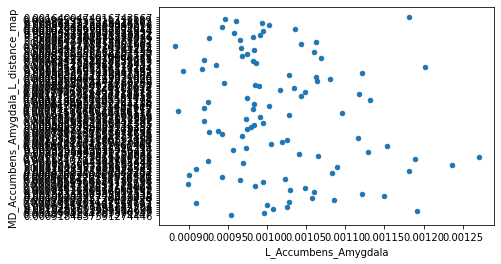

In [344]:
#,delimiter=';'
#ClinicalData = pd.read_excel(CLI_FILE,index_col=1,engine='openpyxl',converters={'PatientID':str,'PatientNB':str})
#os.path.join(STUDY_PATH,'BdD_DTIAnx2.csv')
#ClinicalData = ClinicalData[ClinicalData.index.notnull()]
#ClinicalData = ClinicalData[ClinicalData.filter(regex='^(?!Unnamed)').columns]
test_corrFA_MD=df_DTP[full_list].merge(df_ANX_MD_SPE,on='subject_id')
#g = sns.jointplot(x="L_Accumbens_Amygdala", y='MD_Accumbens_Amygdala_L_distance_map',data=test_corrFA_MD,kind="reg", truncate=False,color="m", height=7)
#ClinicalData = ClinicalData[ClinicalData.filter(regex='^(?!Unnamed)').columns]
test_corrFA_MD.plot(x='L_Accumbens_Amygdala',y='MD_Accumbens_Amygdala_L_distance_map',kind='scatter')

In [300]:
ax = sns.violinplot(x="GROUP_Anx_NonAnx", y="MD_Accumbens_Amygdala_L_distance_map",data=test_corrFA_MD,split=True,inner="quartile")

TypeError: No loop matching the specified signature and casting was found for ufunc add

In [278]:
start_list=['subject_id', 'group_Quentin','GROUP_Anx_NonAnx','GROUP_COG','center', 'sex', 'age', 'education','MMSE_TOT']#,'MDS_HY'
#list_FA = [1 for col in df_DTP.columns if col.endswith('distance_map')]
list_FA = [1 for col in test.columns if col.startswith('FA')]
print(len(list_FA))
list_MD = [0 for col in test.columns if col.startswith('MD')]
print(len(start_list))
print(len(list_MD))
print(len(list_FA+list_MD))
print(len(start_list+list_FA+list_MD))
print(test.shape)
print(list_FA+list_MD)
np.savetxt(os.path.join(STUDY_PATH,'GroupesVar_n2.csv'),np.asanyarray(list_FA+list_MD),delimiter=',')

1059
9
819
1878
1887
(101, 1887)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [28]:
test=df_DTP[full_list]
test.to_csv(os.path.join(STUDY_PATH,'DATA_DTP_20210518.csv'))
test=test.drop(['MDS_HY'],axis=1)
#test=test.loc[test["MD_ST_FO_right_distance_map_6"]>0]
test=test.loc[test["MD_ST_FO_right_distance_map_6"]>0]

p_vals=[]
col_list=[]

for col in test.columns[10:]:
    #print(col)
    values_controls=test[test['GROUP_Anx_NonAnx']==1][col]
    values_patients=test[test['GROUP_Anx_NonAnx']==0][col]
    stats, pvalues = scipy.stats.ttest_ind(values_controls, values_patients)
    p_vals.append(pvalues)
    col_list.append(col)
#    if (p_val<0.05) :
#        print(col,p_val)
b_fdr,ps_fdr=sm.stats.multitest.fdrcorrection(p_vals,alpha=0.05,method='indep',is_sorted=False)  
inds=np.where(np.asanyarray(p_vals)<0.05)
for ind in inds[0] :
    print(p_vals[ind])
    print(col_list[ind])

TypeError: '>' not supported between instances of 'str' and 'int'

In [276]:
list_fr=[]
count=0
for NR_POINTS in ([20]):
    for ALGORITHM in (['''distance_map''']):#'''equal_dist''','''distance_map''','''cutting_plane''','''afq''']): 
        for PARA in (['''FA''','''MD''']): 
            for BUNDLE in listeSpecific + listeGeneric:#,
                if BUNDLE in listeSpecific :
                    for LAT in (['''L''','''R''']):            
                        Profiles_file=os.path.join(STUDY_PATH,'DTIanx','TractometrySpecificTracts',PARA+"_"+LAT+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")
                        if PARA+"_"+BUNDLE+"_"+LAT+"_"+ALGORITHM in test.columns:
                            list_fr.append(count);count=count+1
                        else :
                            print(Profiles_file)
                else :
                    for LAT in (['''left''','''right''']):                    
                        Profiles_file=os.path.join(STUDY_PATH,'tractometry',PARA+"_"+BUNDLE+"_"+LAT+"_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")                    
                        if PARA+"_"+BUNDLE+"_"+LAT+"_"+ALGORITHM+"_20" in test.columns:                            
                            #list_fr.append(np.ones(20)*count)
                            for val in np.ones(20)*count :
                                list_fr.append(val) 
                            count=count+1
                        else :
                            print(Profiles_file)
print(np.asanyarray(list_fr))
np.savetxt(os.path.join(STUDY_PATH,'GroupesVar_n205.csv'),np.asanyarray(list_fr),delimiter=',')

/NAS/dumbo/protocoles/CogPhenoPark/DTIanx/TractometrySpecificTracts/FA_R_Amygdala_mForb_distance_map_20.npy
/NAS/dumbo/protocoles/CogPhenoPark/tractometry/FA_ST_POSTC_left_distance_map_20.npy
/NAS/dumbo/protocoles/CogPhenoPark/tractometry/FA_T_PREF_right_distance_map_20.npy
/NAS/dumbo/protocoles/CogPhenoPark/DTIanx/TractometrySpecificTracts/MD_R_Amygdala_mForb_distance_map_20.npy
/NAS/dumbo/protocoles/CogPhenoPark/tractometry/MD_SLF_III_left_distance_map_20.npy
/NAS/dumbo/protocoles/CogPhenoPark/tractometry/MD_ST_OCC_left_distance_map_20.npy
/NAS/dumbo/protocoles/CogPhenoPark/tractometry/MD_ST_PAR_right_distance_map_20.npy
/NAS/dumbo/protocoles/CogPhenoPark/tractometry/MD_ST_PREC_right_distance_map_20.npy
/NAS/dumbo/protocoles/CogPhenoPark/tractometry/MD_ST_PREF_left_distance_map_20.npy
/NAS/dumbo/protocoles/CogPhenoPark/tractometry/MD_STR_left_distance_map_20.npy
/NAS/dumbo/protocoles/CogPhenoPark/tractometry/MD_T_OCC_left_distance_map_20.npy
/NAS/dumbo/protocoles/CogPhenoPark/tractom

In [280]:
g = sns.jointplot(x="MMSE_TOT", y="group_Quentin",data=df_DTP,kind="reg",truncate=False,color="m", height=7)

26

In [282]:
test[test['GROUP_Anx_NonAnx']==0]

,subject_id,group_Quentin,GROUP_Anx_NonAnx,GROUP_COG,center,sex,age,education,MMSE_TOT,FA_Accumbens_Amygdala_L_distance_map,...,MD_UF_right_distance_map_11,MD_UF_right_distance_map_12,MD_UF_right_distance_map_13,MD_UF_right_distance_map_14,MD_UF_right_distance_map_15,MD_UF_right_distance_map_16,MD_UF_right_distance_map_17,MD_UF_right_distance_map_18,MD_UF_right_distance_map_19,MD_UF_right_distance_map_20
0,T84028,0,0.0,0.0,2,1,41,10,30.0,0.308855,...,0.000747345,0.000759084,0.000796827,0.000775755,0.000779679,0.00078722,0.000787568,0.000788625,0.00077712,0.000762083
1,T84025,3,0.0,3.0,2,0,63,14,30.0,0.281667,...,0.000808545,0.000859968,0.000930237,0.000896377,0.000832345,0.000843772,0.000863103,0.00086448,0.000866433,0.00084732
2,640524MB240413,3,0.0,3.0,1,0,49,10,29.0,0.192322,...,0.000807856,0.000828647,0.000806916,0.000823699,0.000821177,0.000799962,0.000791349,0.000814125,0.000825627,0.000809649
3,160858ZFK130321,3,0.0,3.0,1,0,55,12,26.0,0.28753,...,0.0007848,0.000754628,0.000749611,0.000736558,0.000734466,0.000761747,0.000755911,0.000768205,0.000782408,0.000791849
4,480227MS04042013,3,0.0,3.0,1,0,65,8,26.0,0.299845,...,0.000884837,0.000847316,0.000810406,0.000803641,0.000805813,0.000782033,0.000783128,0.000790901,0.000788337,0.000786736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,T84075,0,0.0,0.0,2,1,70,18,30.0,0.281514,...,0.000881643,0.000894225,0.000922462,0.0010062,0.000981757,0.000943431,0.000949093,0.000935721,0.000918394,0.000895789
98,T84076,0,0.0,0.0,2,1,65,15,29.0,0.260295,...,0.000817537,0.000823118,0.000811423,0.000824801,0.000815681,0.000811726,0.000815244,0.000811347,0.000821089,0.00083121
100,590529AT130314,2,0.0,2.0,1,1,55,12,28.0,0.332879,...,0.000825059,0.000820039,0.000835245,0.000826117,0.000834387,0.000844019,0.000832956,0.000841039,0.000839213,0.000829031
102,T84029,0,0.0,0.0,2,1,57,10,30.0,0.288566,...,0.000790107,0.00079877,0.000800753,0.000781094,0.000799197,0.000802096,0.000808559,0.000834871,0.000867601,0.000866734


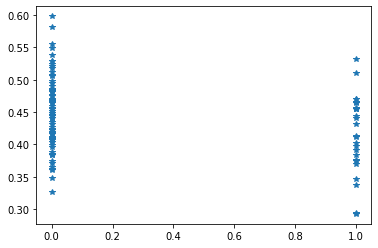

In [234]:
#ax = sns.violinplot(x="GROUP_Anx_NonAnx", y="MD_ST_FO_right_distance_map_6",data=test,split=True,inner="quartile")
plt.plot(test["GROUP_Anx_NonAnx"], test["FA_SLF_II_right_distance_map_13"],'*') 

In [9]:
meanLengths=list()
stdLengths=list()
for BUNDLE in listeSpecific :
    for LAT in (['''L''','''R''']):
        print(BUNDLE,LAT)
        #npvalues = np.zeros([len(df),NR_POINTS])
        for idx, jdx in df.iterrows():
            SUBJ=df.iloc[idx]['subject_id']
            print(idx,SUBJ)
            TRACTO_TCK=os.path.join(STUDY_PATH,"DTIanx","Manual_Bunddle_Seg",SUBJ,'iFOD',"LIFE",LAT+"_"+BUNDLE+'_LIFE.tck')
            if os.path.exists(TRACTO_TCK) :
                sl_file = nib.streamlines.load(TRACTO_TCK)
                streamlines = sl_file.streamlines            
                meanLengths.append(np.mean(list(length(streamlines))))
                stdLengths.append(np.std(list(length(streamlines))))
                df.loc[idx,BUNDLE+'_'+LAT+'_'+"_nbStreamlines"]=len(streamlines)
                df.loc[idx,BUNDLE+'_'+LAT+'_'+"_meanStreamlinesLength"]=np.mean(list(length(streamlines)))
                df.loc[idx,BUNDLE+'_'+LAT+'_'+"_stdStreamlinesLength"]=np.std(list(length(streamlines)))
        print(np.mean(meanLengths),np.mean(stdLengths))

Accumbens_Amygdala L
0 T84028
1 T84025
2 640524MB240413
3 160858ZFK130321
4 480227MS04042013
5 470214CP110413
6 470130MY220513
7 540626CR180713
8 480628EH250713
9 340531NS060613
10 490526RD170613
11 520818CL110713
12 420428MM091213
13 360108LW050214
14 440404JPT240214
15 380614TM060314
16 541227MN050614
17 420123JO160614
18 631221AM300614
19 501009DL030714
20 T84008
21 T84011
22 T84017
23 T84021
24 T84042
25 T84045
26 T84061
27 T84062
28 540424GD290114_PB
29 490815MPD280313
30 360210FG230513
31 420620AC050813
32 370217OD260913
33 560826AR050913
34 461119BA31102013
35 521205MD190214
36 460616BC240314
37 340910RL270314
38 511209MT030414
39 530516NL100414
40 550129PB170714
41 T84010
42 T84013
43 T84018
44 T84024
45 T84039
46 T84043
47 T84046
48 T84049
49 T84079
50 480412JL141113
51 581109PF281113
52 710624PD121213
53 381103AD070414
54 181037MB070714
55 T84006
56 T84027
57 T84034
58 T84041
59 T84054
60 T84055
61 T84067
62 T84077
63 T84078
64 380304JM130613
65 491029AS010813
66 460829CC0909

KeyboardInterrupt: 

In [ ]:
#df = pd.DataFrame()
meanLengths=list()
stdLengths=list()
for BUNDLE in listeGeneric : #(['''ST_OCC''','''ST_PAR''','''ST_POSTC''','''ST_PREC''','''ST_PREF''','''ST_PREM''','''STR''','''T_OCC''','''T_PAR''','''T_POSTC''','''T_PREC''','''T_PREF''','''T_PREM''','''UF''']):# listeGeneric :
    for LAT in (['''left''','''right''']):
        print(BUNDLE,LAT)
        #npvalues = np.zeros([len(df),NR_POINTS])
        for idx, jdx in df.iterrows():
            SUBJ=df.iloc[idx]['subject_id']
            TRACTO_TCK=os.path.join(TRACTO_DIR,SUBJ,'FOD_iFOD2_trackings',BUNDLE+'_'+LAT+'.tck')
            if os.path.exists(TRACTO_TCK) :
                sl_file = nib.streamlines.load(TRACTO_TCK)
                streamlines = sl_file.streamlines            
                meanLengths.append(np.mean(list(length(streamlines))))
                stdLengths.append(np.std(list(length(streamlines))))
                df.loc[idx,BUNDLE+"_nbStreamlines"]=len(streamlines)
                df.loc[idx,BUNDLE+"_meanStreamlinesLength"]=np.mean(list(length(streamlines)))
                df.loc[idx,BUNDLE+"_stdStreamlinesLength"]=np.std(list(length(streamlines)))                           
        print(np.mean(meanLengths),np.mean(stdLengths))

ST_OCC left
90.94305 22.957996
ST_OCC right
87.85104 23.078754
ST_PAR left
84.41107 23.463352
ST_PAR right
82.96179 23.957449
ST_POSTC left
78.42284 22.220463
ST_POSTC right
75.28026 20.979803
ST_PREC left
73.42702 20.392698
ST_PREC right
71.87142 19.755531
ST_PREF left
71.521225 19.787834
ST_PREF right
71.01406 19.691174
ST_PREM left
69.28053 18.8637
ST_PREM right
67.73736 18.034983
STR left


/home/romain/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
/home/romain/.local/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
/home/romain/.local/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/romain/.local/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
/home/romain/.local/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


nan nan
STR right
nan nan
T_OCC left
nan nan
T_OCC right
nan nan
T_PAR left
nan nan
T_PAR right
nan nan
T_POSTC left
nan nan
T_POSTC right
nan nan
T_PREC left
nan nan
T_PREC right
nan nan
T_PREF left


In [23]:
df=pd.read_csv(os.path.join(STUDY_PATH,'DATA_DTP_FULL_FA_MD_RD_AD_GA_AFD_NUFO.csv'),decimal=",")
print(df.shape,df.columns)
df_DTP=pd.read_csv(os.path.join(STUDY_PATH,'DATA_DTP_FA_MD_RD_AD_GA_AFDx_NUFO_20210611.csv'),decimal=",")
print(df_DTP.shape,df_DTP.columns)
print(len(listeSpecific)*2+len(listeGeneric)*2*20)
set(df.subject_id)-set(df_DTP.subject_id)

(107, 9576) Index(['subject_id', 'center', 'sex', 'age', 'education',
       'FA_Accumbens_Amygdala_L_distance_map',
       'FA_Accumbens_Amygdala_R_distance_map',
       'FA_Accumbens_cACC_L_distance_map', 'FA_Accumbens_cACC_R_distance_map',
       'FA_Accumbens_Insula_L_distance_map',
       ...
       'afd_max_UF_right_distance_map_11', 'afd_max_UF_right_distance_map_12',
       'afd_max_UF_right_distance_map_13', 'afd_max_UF_right_distance_map_14',
       'afd_max_UF_right_distance_map_15', 'afd_max_UF_right_distance_map_16',
       'afd_max_UF_right_distance_map_17', 'afd_max_UF_right_distance_map_18',
       'afd_max_UF_right_distance_map_19', 'afd_max_UF_right_distance_map_20'],
      dtype='object', length=9576)
(107, 8481) Index(['subject_id', 'GROUP_Anx_NonAnx', 'GROUP_COG', 'center', 'sex', 'age',
       'education', 'MMSE_TOT', 'FA_Accumbens_Amygdala_L_distance_map',
       'FA_Accumbens_Amygdala_R_distance_map',
       ...
       'afd_sum_UF_right_distance_map_11', 'afd_su

set()

<AxesSubplot:xlabel='GROUP_Anx_NonAnx', ylabel='FA_Thalamus_Caudate_R_distance_map'>

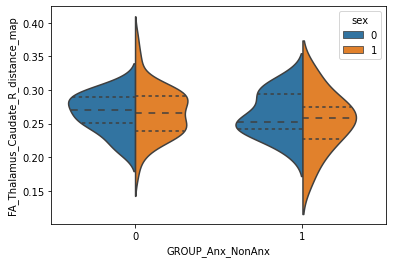

0.26706038745092775 0.034783588899235274
0.2577881372147261 0.03733123058904743
FA_Thalamus_Caudate_R_distance_map 1.21271932471237 0.22795858401415117
0.23976529058578663 0.03222504857115309
0.24267130081393581 0.03208991641055371
FA_Accumbens_Insula_R_distance_map -0.4196905914164438 0.6755689850153633


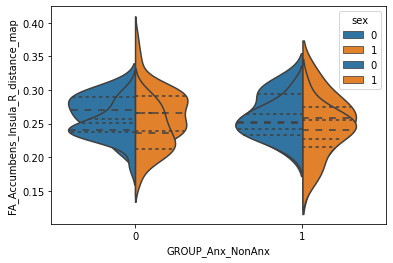

In [54]:
p_vals=[]
col_list=[]
df_DTP['GROUP_Anx_NonAnx'] = df_DTP.GROUP_Anx_NonAnx.astype('category')

for col in ["FA_Thalamus_Caudate_R_distance_map","FA_Accumbens_Insula_R_distance_map"] :
    #print(col)
    df_DTP[col]=pd.to_numeric(df_DTP[col])
    values_controls=df_DTP[df_DTP['GROUP_Anx_NonAnx']==0][col]
    values_patients=df_DTP[df_DTP['GROUP_Anx_NonAnx']==1][col]
    stats, pvalues = scipy.stats.ttest_ind(values_controls, values_patients)
    print(np.mean(values_controls),np.std(values_controls))
    print(np.mean(values_patients),np.std(values_patients))
    print(col,stats,pvalues)
    sns.violinplot(x="GROUP_Anx_NonAnx",y=col,hue="sex",split=True,inner="quartile",data=df_DTP)
    p_vals.append(pvalues)
    col_list.append(col)
#    if (p_val<0.05) :
#        print(col,p_val)
b_fdr,ps_fdr=sm.stats.multitest.fdrcorrection(p_vals,alpha=0.05,method='indep',is_sorted=False)  
inds=np.where(np.asanyarray(p_vals)<0.05)
for ind in inds[0] :
    print(p_vals[ind])
    print(col_list[ind])intranet

In [108]:
listFile=list()
print(df2.shape,df2.columns)
for NR_POINTS in ([20]):
    for ALGORITHM in (['''distance_map''']):#'''equal_dist''','''distance_map''','''cutting_plane''','''afq''']): 
        for PARA in (['''afd_max''']): #(['''ga''',''''afd_max''','''afd_total''','''afd_sum''','''nufo''']): #(['''AD''','''RD''']): 
            for BUNDLE in listeSpecific + listeGeneric:
                if BUNDLE in listeSpecific :
                    for LAT in (['''L''','''R''']):            
                        Profiles_file=os.path.join(STUDY_PATH,'DTIanx','TractometrySpecificTracts',PARA+"_"+LAT+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")
                        if os.path.exists(Profiles_file) :
                            npvalues=np.load(Profiles_file)
                            df2[PARA+"_"+BUNDLE+"_"+LAT+"_"+ALGORITHM]=np.mean(npvalues,axis=1)  
                            listFile.append(Profiles_file)
                        else :
                            print(Profiles_file)
                else :
                    for LAT in (['''left''','''right''']):                    
                        Profiles_file=os.path.join(STUDY_PATH,'tractometry',PARA+"_"+BUNDLE+"_"+LAT+"_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")                    
                        if os.path.exists(Profiles_file) :
                            npvalues=np.load(Profiles_file)
                            mylist=list(df2.columns)
                            for it in np.linspace(1,20,20):
                                mylist.append(PARA+"_"+BUNDLE+"_"+LAT+"_"+ALGORITHM+"_"+(str(int(it))))
                            df2=pd.DataFrame(pd.np.column_stack([df2, npvalues]),columns=mylist)
                            listFile.append(Profiles_file)                            
                        else :
                            print(Profiles_file)
print(df2.shape,df2.columns)
df2
#df2.to_csv(os.path.join(STUDY_PATH,'DATA_DTP_FULL_FA_MD_RD_AD_GA_AFD_NUFO.csv'))

(107, 8478) Index(['subject_id', 'Unnamed: 0', 'center', 'sex', 'age', 'education',
       'FA_Accumbens_Amygdala_L_distance_map',
       'FA_Accumbens_Amygdala_R_distance_map',
       'FA_Accumbens_cACC_L_distance_map', 'FA_Accumbens_cACC_R_distance_map',
       ...
       'nufo_UF_right_distance_map_11', 'nufo_UF_right_distance_map_12',
       'nufo_UF_right_distance_map_13', 'nufo_UF_right_distance_map_14',
       'nufo_UF_right_distance_map_15', 'nufo_UF_right_distance_map_16',
       'nufo_UF_right_distance_map_17', 'nufo_UF_right_distance_map_18',
       'nufo_UF_right_distance_map_19', 'nufo_UF_right_distance_map_20'],
      dtype='object', length=8478)
/NAS/dumbo/protocoles/CogPhenoPark/DTIanx/TractometrySpecificTracts/afd_max_R_Amygdala_mForb_distance_map_20.npy


/home/global/anaconda37/bin/xpython:24: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


(107, 9577) Index(['subject_id', 'Unnamed: 0', 'center', 'sex', 'age', 'education',
       'FA_Accumbens_Amygdala_L_distance_map',
       'FA_Accumbens_Amygdala_R_distance_map',
       'FA_Accumbens_cACC_L_distance_map', 'FA_Accumbens_cACC_R_distance_map',
       ...
       'afd_max_UF_right_distance_map_11', 'afd_max_UF_right_distance_map_12',
       'afd_max_UF_right_distance_map_13', 'afd_max_UF_right_distance_map_14',
       'afd_max_UF_right_distance_map_15', 'afd_max_UF_right_distance_map_16',
       'afd_max_UF_right_distance_map_17', 'afd_max_UF_right_distance_map_18',
       'afd_max_UF_right_distance_map_19', 'afd_max_UF_right_distance_map_20'],
      dtype='object', length=9577)


,subject_id,Unnamed: 0,center,sex,age,education,FA_Accumbens_Amygdala_L_distance_map,FA_Accumbens_Amygdala_R_distance_map,FA_Accumbens_cACC_L_distance_map,FA_Accumbens_cACC_R_distance_map,FA_Accumbens_Insula_L_distance_map,FA_Accumbens_Insula_R_distance_map,FA_Accumbens_lForb_L_distance_map,FA_Accumbens_lForb_R_distance_map,FA_Accumbens_mForb_L_distance_map,FA_Accumbens_mForb_R_distance_map,FA_Accumbens_rACC_L_distance_map,FA_Accumbens_rACC_R_distance_map,FA_Accumbens_Thalamus_L_distance_map,FA_Accumbens_Thalamus_R_distance_map,FA_Amygdala_Caudate_L_distance_map,FA_Amygdala_Caudate_R_distance_map,FA_Amygdala_Insula_L_distance_map,FA_Amygdala_Insula_R_distance_map,FA_Amygdala_lForb_L_distance_map,FA_Amygdala_lForb_R_distance_map,FA_Amygdala_Putamen_L_distance_map,FA_Amygdala_Putamen_R_distance_map,FA_Amygdala_rACC_L_distance_map,FA_Amygdala_rACC_R_distance_map,FA_Amygdala_Thalamus_L_distance_map,FA_Amygdala_Thalamus_R_distance_map,FA_Caudate_cACC_L_distance_map,FA_Caudate_cACC_R_distance_map,FA_Caudate_Insula_L_distance_map,FA_Caudate_Insula_R_distance_map,FA_Caudate_lForb_L_distance_map,FA_Caudate_lForb_R_distance_map,FA_Caudate_mForb_L_distance_map,FA_Caudate_mForb_R_distance_map,FA_Caudate_rACC_L_distance_map,FA_Caudate_rACC_R_distance_map,FA_Putamen_cACC_L_distance_map,FA_Putamen_cACC_R_distance_map,FA_Putamen_Insula_L_distance_map,FA_Putamen_Insula_R_distance_map,FA_Putamen_lForb_L_distance_map,FA_Putamen_lForb_R_distance_map,FA_Putamen_mForb_L_distance_map,FA_Putamen_mForb_R_distance_map,FA_Putamen_rACC_L_distance_map,FA_Putamen_rACC_R_distance_map,FA_Thalamus_Caudate_L_distance_map,FA_Thalamus_Caudate_R_distance_map,FA_Thalamus_Insula_L_distance_map,FA_Thalamus_Insula_R_distance_map,FA_Thalamus_lForb_L_distance_map,FA_Thalamus_lForb_R_distance_map,FA_Thalamus_mForb_L_distance_map,FA_Thalamus_mForb_R_distance_map,FA_Thalamus_Putamen_L_distance_map,FA_Thalamus_Putamen_R_distance_map,FA_Thalamus_rACC_L_distance_map,FA_Thalamus_rACC_R_distance_map,FA_Amygdala_mForb_L_distance_map,FA_AF_left_distance_map_1,FA_AF_left_distance_map_2,FA_AF_left_distance_map_3,FA_AF_left_distance_map_4,FA_AF_left_distance_map_5,FA_AF_left_distance_map_6,FA_AF_left_distance_map_7,FA_AF_left_distance_map_8,FA_AF_left_distance_map_9,FA_AF_left_distance_map_10,FA_AF_left_distance_map_11,FA_AF_left_distance_map_12,FA_AF_left_distance_map_13,FA_AF_left_distance_map_14,FA_AF_left_distance_map_15,FA_AF_left_distance_map_16,FA_AF_left_distance_map_17,FA_AF_left_distance_map_18,FA_AF_left_distance_map_19,FA_AF_left_distance_map_20,FA_AF_right_distance_map_1,FA_AF_right_distance_map_2,FA_AF_right_distance_map_3,FA_AF_right_distance_map_4,FA_AF_right_distance_map_5,FA_AF_right_distance_map_6,FA_AF_right_distance_map_7,FA_AF_right_distance_map_8,FA_AF_right_distance_map_9,FA_AF_right_distance_map_10,FA_AF_right_distance_map_11,...,afd_max_T_PREF_right_distance_map_5,afd_max_T_PREF_right_distance_map_6,afd_max_T_PREF_right_distance_map_7,afd_max_T_PREF_right_distance_map_8,afd_max_T_PREF_right_distance_map_9,afd_max_T_PREF_right_distance_map_10,afd_max_T_PREF_right_distance_map_11,afd_max_T_PREF_right_distance_map_12,afd_max_T_PREF_right_distance_map_13,afd_max_T_PREF_right_distance_map_14,afd_max_T_PREF_right_distance_map_15,afd_max_T_PREF_right_distance_map_16,afd_max_T_PREF_right_distance_map_17,afd_max_T_PREF_right_distance_map_18,afd_max_T_PREF_right_distance_map_19,afd_max_T_PREF_right_distance_map_20,afd_max_T_PREM_left_distance_map_1,afd_max_T_PREM_left_distance_map_2,afd_max_T_PREM_left_distance_map_3,afd_max_T_PREM_left_distance_map_4,afd_max_T_PREM_left_distance_map_5,afd_max_T_PREM_left_distance_map_6,afd_max_T_PREM_left_distance_map_7,afd_max_T_PREM_left_distance_map_8,afd_max_T_PREM_left_distance_map_9,afd_max_T_PREM_left_distance_map_10,afd_max_T_PREM_left_distance_map_11,afd_max_T_PREM_left_distance_map_12,afd_max_T_PREM_left_distance_map_13,afd_max_T_PREM_left_distance_map_14,afd_max_T_PREM_left_distance_map_15,afd_max_T_PREM_left_distance_ma

In [105]:
df2.subject_id
#df2.to_csv(os.path.join(STUDY_PATH,'DATA_DTP_FULL_FA_MD_RD_AD_GA_AFD_NUFO.csv'))

AttributeError: 'DataFrame' object has no attribute 'subject_id'